In [1]:
import sys
import xml.etree.ElementTree as ET
from collections import Counter
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import random
import cv2
import matplotlib.pyplot as plt
from IPython.display import Video
import torch
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import draw_bounding_boxes, make_grid

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("CV2 version : ", cv2.__version__)
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)

Platform: win32
Python version: 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
---
CV2 version :  4.11.0
torch version :  2.2.2+cpu
torchvision version :  0.17.2+cpu


In [3]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [4]:
cocoa_data_dir =  Path("train")

print("Data directory:", cocoa_data_dir)

Data directory: train


In [5]:
cocoa_files = list(cocoa_data_dir.iterdir())
cocoa_files[-5:]

[WindowsPath('train/Bj_Buruk (147).xml'),
 WindowsPath('train/Bj_Buruk (148).jpg'),
 WindowsPath('train/Bj_Buruk (148).xml'),
 WindowsPath('train/Bj_Buruk (149).jpg'),
 WindowsPath('train/Bj_Buruk (149).xml')]

In [6]:
file_extension_counts = Counter(Path(file).suffix for file in cocoa_files)

for extension, count in file_extension_counts.items():
    print(f"Files with extension {extension}: {count}")

Files with extension .jpg: 72
Files with extension .xml: 72


In [7]:
from pathlib import Path
import xml.etree.ElementTree as ET
import cv2

cocoa_data_dir = Path("train")
images_dir = cocoa_data_dir  # both jpg and xml are in same folder
resized_images_dir = cocoa_data_dir / "resized/images"
resized_annotations_dir = cocoa_data_dir / "resized/annotations"

resized_images_dir.mkdir(parents=True, exist_ok=True)
resized_annotations_dir.mkdir(parents=True, exist_ok=True)

# Resize target
resize_width, resize_height = 640, 640

# Resize and update XML
for image_path in images_dir.glob("*.jpg"):
    image_name = image_path.stem
    xml_path = images_dir / f"{image_name}.xml"

    # Check if XML exists
    if not xml_path.exists():
        print(f"⚠️ Skipping: No annotation for {image_path.name}")
        continue

    # === Read and resize image ===
    image = cv2.imread(str(image_path))  # BGR format
    if image is None:
        print(f"❌ Failed to load {image_path}")
        continue

    orig_h, orig_w = image.shape[:2]
    image_resized = cv2.resize(image, (resize_width, resize_height))

    # === Save resized image in BGR ===
    save_image_path = resized_images_dir / image_path.name
    cv2.imwrite(str(save_image_path), image_resized)

    # === Parse and update annotation ===
    tree = ET.parse(str(xml_path))
    root = tree.getroot()

    for size in root.iter("size"):
        size.find("width").text = str(resize_width)
        size.find("height").text = str(resize_height)

    for obj in root.iter("object"):
        xml_box = obj.find("bndbox")
        xmin = int(xml_box.find("xmin").text)
        ymin = int(xml_box.find("ymin").text)
        xmax = int(xml_box.find("xmax").text)
        ymax = int(xml_box.find("ymax").text)

        # Scale coordinates
        xmin = int(xmin * resize_width / orig_w)
        xmax = int(xmax * resize_width / orig_w)
        ymin = int(ymin * resize_height / orig_h)
        ymax = int(ymax * resize_height / orig_h)

        xml_box.find("xmin").text = str(xmin)
        xml_box.find("xmax").text = str(xmax)
        xml_box.find("ymin").text = str(ymin)
        xml_box.find("ymax").text = str(ymax)

    # === Save updated annotation ===
    save_xml_path = resized_annotations_dir / xml_path.name
    tree.write(str(save_xml_path))

print("✅ Done resizing images and annotations.")


✅ Done resizing images and annotations.


### Annotations

In [9]:
from pathlib import Path

# Define annotations directory based on your resized data folder
annotations_dir = Path("train/resized/annotations")

# Choose a specific XML file to inspect
xml_filepath = annotations_dir / "Bj_baik (10).xml"

# Read first 25 lines to verify content
with open(xml_filepath, 'r') as file:
    for _ in range(25):
        print(file.readline())


<annotation>

	<folder>my-project-name</folder>

	<filename>Bj_baik (10).jpg</filename>

	<path>/my-project-name/Bj_baik (10).jpg</path>

	<source>

		<database>Unspecified</database>

	</source>

	<size>

		<width>640</width>

		<height>640</height>

		<depth>3</depth>

	</size>

	<object>

		<name>good</name>

		<pose>Unspecified</pose>

		<truncated>0</truncated>

		<difficult>0</difficult>

		<bndbox>

			<xmin>216</xmin>

			<ymin>154</ymin>

			<xmax>340</xmax>

			<ymax>389</ymax>

		</bndbox>

	</object>

</annotation>


In [10]:
tree = ET.parse(xml_filepath)
root = tree.getroot()
print(root.tag)

annotation


In [11]:
width = int(root.find("size").find("width").text)
height = int(root.find("size").find("height").text)
print(f"image width: {width}  image height: {height}")

image width: 640  image height: 640


In [12]:
bounding_boxes = []
labels = []
for obj in root.findall("object"):
    label = obj.find("name").text
    labels.append(label)
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    bounding_boxes.append([xmin, ymin, xmax, ymax])

for label, bounding_box in zip(labels, bounding_boxes):
    print(f"{label}: {bounding_box}")

good: [216, 154, 340, 389]


### Bounding Boxes in Pytorch

In [13]:
bboxes_tensor = torch.tensor(bounding_boxes, dtype=torch.float)

print(bboxes_tensor)

tensor([[216., 154., 340., 389.]])


In [14]:
images_dir = Path("train/resized/images")

image_path = images_dir/ 'Bj_baik (10).jpg'
image = read_image(str(image_path))
print(image.shape)

torch.Size([3, 640, 640])


In [15]:
image = draw_bounding_boxes(
    image=image,
    boxes=bboxes_tensor,
    labels=labels,
    width=3,
    fill=False,
    font="arial.ttf",
    font_size=10,
)

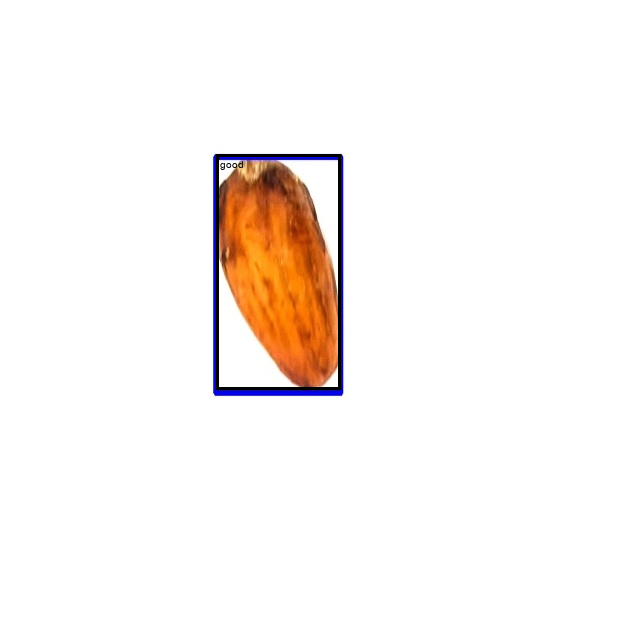

In [16]:
to_pil_image(image)

### Data Transformation

In [26]:
classes = [
    "good",
    "poor"
]

In [27]:
for idx, val in enumerate(classes):
    print(idx, val)

0 good
1 poor


In [28]:
class_mapping = {cls: idx for idx, cls in enumerate(classes)}

print(class_mapping)

{'good': 0, 'poor': 1}


In [29]:
width = 640
height = 640
xmin = 833
ymin = 390
xmax = 1087
ymax = 800

In [30]:
x_center = (xmax + xmin) / 2 / width
y_center = (ymax + ymin) / 2 / height

print(f"Bounding box center: ({x_center}, {y_center})")

Bounding box center: (1.5, 0.9296875)


In [31]:
bb_width = (xmax - xmin) / width
bb_height = (ymax-ymin) / height

print(f"Bounding box size: {bb_width:0.3f} ⨯ {bb_height:0.3f}")

Bounding box size: 0.397 ⨯ 0.641


In [32]:
def xml_to_yolo_bbox(bbox, width, height):
    """Convert the XML bounding box coordinates into YOLO format.

    Input:  bbox    The bounding box, defined as [xmin, ymin, xmax, ymax],
                    measured in pixels.
            width   The image width in pixels.
            height  The image height in pixels.

    Output: [x_center, y_center, bb_width, bb_height], where the bounding
            box is centered at (x_center, y_center) and is of size
            bb_width x bb_height.  All values are measured as a fraction
            of the image size."""

    xmin, ymin, xmax, ymax = bbox
    x_center = (xmax + xmin) / 2 / width
    y_center = (ymax + ymin) / 2 / height
    bb_width = (xmax - xmin) / width
    bb_height = (ymax-ymin) / height


    return [x_center, y_center, bb_width, bb_height]


xml_to_yolo_bbox([xmin, ymin, xmax, ymax], width, height)

[1.5, 0.9296875, 0.396875, 0.640625]

In [33]:
def parse_annotations(f):
    """Parse all of the objects in a given XML file to YOLO format.

    Input:  f      The path of the file to parse.

    Output: A list of objects in YOLO format.
            Each object is a list [index, x_center, y_center, width, height]."""

    objects = []

    tree = ET.parse(f)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall("object"):
        label = obj.find("name").text
        class_id = class_mapping[label]
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        yolo_bbox = xml_to_yolo_bbox([xmin, ymin, xmax, ymax], width, height)

        objects.append([class_id] + yolo_bbox)

    return objects


objects = parse_annotations(annotations_dir / "Bj_baik (10).xml")
print("First object:", objects[0])

First object: [0, 0.434375, 0.42421875, 0.19375, 0.3671875]


In [35]:
classes[1]

'poor'

In [36]:
def write_label(objects, filename):
    with open(filename, "w") as f:
        for obj in objects:
            line = " ".join(f"{x:.6f}" if isinstance(x, float) else str(x) for x in obj)
            f.write(line + "\n")


In [37]:
write_label(objects, "yolo_test.txt")
!head -n 1 yolo_test.txt

'head' is not recognized as an internal or external command,
operable program or batch file.


In [39]:
N = 1
with open("yolo_test.txt", "r") as f:
    lines = [next(f).strip() for _ in range(N)]
    for line in lines:
        print(line)

0 0.434375 0.424219 0.193750 0.367188


### Preparing the Directory Structure

In [42]:
import shutil

In [43]:
import pathlib

In [44]:
yolo_base = pathlib.Path("data_yolo")

# It's important to clear out the directory, if it already
# exists.  We'll get a different train / validation split
# each time, so we need to make sure the old images are
# cleared out.
shutil.rmtree(yolo_base, ignore_errors=True)

(yolo_base / "images" / "train").mkdir(parents=True)
# Create the remaining directories.
(yolo_base / "images" / "val").mkdir(parents=True)
(yolo_base / "labels" / "train").mkdir(parents=True)
(yolo_base / "labels" / "val").mkdir(parents=True)


!tree $yolo_base

Folder PATH listing
Volume serial number is 0000009E 8C78:22B1
C:\USERS\DICKSON\COCOA QUALITY\DATA_YOLO
ÃÄÄÄimages
³   ÃÄÄÄtrain
³   ÀÄÄÄval
ÀÄÄÄlabels
    ÃÄÄÄtrain
    ÀÄÄÄval


In [45]:
train_frac = 0.8
images = list(images_dir.glob("*.jpg"))

for img in tqdm(images):
    split = "train" if random.random() < train_frac else "val"
    annotation = annotations_dir / f"{img.stem}.xml"

    try:
        parsed = parse_annotations(annotation)
    except Exception as e:
        print(f'Failed to parse "{img.stem}". Skipping.')
        continue

    # Save label
    label_dest = yolo_base / "labels" / split / f"{img.stem}.txt"
    write_label(parsed, label_dest)

    # Copy image (no conversion since already jpg)
    img_dest = yolo_base / "images" / split / f"{img.stem}.jpg"
    shutil.copy(img, img_dest)

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:05<00:00, 13.97it/s]


In [46]:
train_count = len(list((yolo_base / "images" / "train").glob("*")))
val_count = len(list((yolo_base / "images" / "val").glob("*")))
total_count = train_count + val_count

print(f"Training fraction:   {train_count/total_count:0.3f}")
print(f"Validation fraction: {val_count/total_count:0.3f}")

Training fraction:   0.764
Validation fraction: 0.236


### Training the Model

In [47]:
metadata = {
    "path": str(
        yolo_base.absolute()
    ),  # It's easier to specify absolute paths with YOLO.
    
    "train": "images/train", # Training images, relative to above.
    
    "val": "images/val", # Validation images
    
    "names": classes, # Class names, as a list
    
    "nc": len(classes), # Number of classes
}

print(metadata)

{'path': 'C:\\Users\\Dickson\\Cocoa Quality\\data_yolo', 'train': 'images/train', 'val': 'images/val', 'names': ['good', 'poor'], 'nc': 2}


In [48]:
import yaml
from pathlib import Path

# Define path
yolo_base = Path("data_yolo")

# Class list
classes = [
    "good",
    "poor"
]

# Prepare metadata
data = {
    'path': str(yolo_base.absolute()),
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(classes),
    'names': classes
}

# Write to YAML
with open('data.yaml', 'w') as f:
    yaml.dump(data, f, default_flow_style=False)


In [49]:
yolo_config = "data.yaml"
# Using yaml.safe_dump() protects you from some oddities in the YAML format.
# It takes the same arguments as json.dump().
yaml.safe_dump(metadata, open(yolo_config, 'w'))


!cat data.yaml

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [50]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

100%|█████████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:04<00:00, 1.49MB/s]


In [51]:
model = YOLO("yolov8n.pt")

# Train the model
model.train(data="data.yaml", epochs=50, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.168 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.105  Python-3.11.3 torch-2.2.2+cpu CPU (Intel Core(TM) i3-5157U 2.50GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

train: Scanning C:\Users\Dickson\Cocoa Quality\data_yolo\labels\train... 55 images, 0 backgrounds, 0 corrupt: 100%|████

train: New cache created: C:\Users\Dickson\Cocoa Quality\data_yolo\labels\train.cache



val: Scanning C:\Users\Dickson\Cocoa Quality\data_yolo\labels\val... 17 images, 0 backgrounds, 0 corrupt: 100%|████████

val: New cache created: C:\Users\Dickson\Cocoa Quality\data_yolo\labels\val.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G     0.8657      3.349      1.067         14        640: 100%|██████████| 4/4 [03:56<00:00, 59.23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<0


                   all         17         17    0.00328          1      0.693       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.6105      2.993     0.9954         10        640: 100%|██████████| 4/4 [01:03<00:00, 15.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<0

                   all         17         17    0.00331          1      0.655      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.6275      2.392     0.9413          8        640: 100%|██████████| 4/4 [01:03<00:00, 15.96
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         17         17    0.00326          1      0.673      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      0.596      1.851      0.926         12        640: 100%|██████████| 4/4 [01:02<00:00, 15.55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<0

                   all         17         17     0.0034          1      0.707      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.5146      1.642     0.8949         22        640: 100%|██████████| 4/4 [01:31<00:00, 22.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         17         17     0.0034          1       0.89      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.5176      1.533     0.9068         14        640: 100%|██████████| 4/4 [00:58<00:00, 14.72
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<0

                   all         17         17    0.00336          1      0.961      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.5079      1.319     0.9423          9        640: 100%|██████████| 4/4 [01:00<00:00, 15.02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17    0.00333          1      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.5555      1.264     0.8885         15        640: 100%|██████████| 4/4 [01:00<00:00, 15.18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0


                   all         17         17          1      0.227      0.995      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.5646      1.333     0.8989         13        640: 100%|██████████| 4/4 [01:01<00:00, 15.25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:19<0

                   all         17         17      0.968      0.916      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.4927        1.2     0.8799         12        640: 100%|██████████| 4/4 [01:01<00:00, 15.40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<0

                   all         17         17      0.982      0.962      0.995      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.5237      1.422     0.9518         10        640: 100%|██████████| 4/4 [00:59<00:00, 14.75
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<0


                   all         17         17          1      0.983      0.995      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.4835      1.268     0.8852          8        640: 100%|██████████| 4/4 [00:59<00:00, 14.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.878       0.88      0.967       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.5304      1.138     0.9207         16        640: 100%|██████████| 4/4 [00:57<00:00, 14.37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17       0.97        0.5      0.939      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.4821      1.395     0.8944         12        640: 100%|██████████| 4/4 [00:57<00:00, 14.29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17       0.93      0.585      0.995      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      0.476       1.19     0.8702         12        640: 100%|██████████| 4/4 [00:55<00:00, 13.98
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.919      0.958      0.987      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.5283      1.197     0.8836         15        640: 100%|██████████| 4/4 [00:56<00:00, 14.08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.959          1      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.4432     0.9928     0.8478         16        640: 100%|██████████| 4/4 [00:56<00:00, 14.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.952          1      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.5188      1.131      0.901         14        640: 100%|██████████| 4/4 [00:56<00:00, 14.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.971          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.4692       1.02     0.8742         14        640: 100%|██████████| 4/4 [00:56<00:00, 14.18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17       0.96      0.971      0.995      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.4658      1.146     0.8703          8        640: 100%|██████████| 4/4 [00:55<00:00, 13.83
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.958      0.917      0.984      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.4766      1.234     0.9207          8        640: 100%|██████████| 4/4 [00:55<00:00, 13.86
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.963      0.997      0.995      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.5199      1.078     0.9234         13        640: 100%|██████████| 4/4 [00:55<00:00, 13.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.993      0.998      0.995      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.5117      1.243     0.8861         12        640: 100%|██████████| 4/4 [00:54<00:00, 13.68
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.951          1      0.995      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.4744      1.071     0.8843         13        640: 100%|██████████| 4/4 [00:54<00:00, 13.74
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.987      0.994      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      0.413      1.036     0.8275         12        640: 100%|██████████| 4/4 [00:55<00:00, 13.78
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.787      0.869      0.931      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      0.461     0.9613     0.8711         13        640: 100%|██████████| 4/4 [00:55<00:00, 13.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.761       0.89      0.976      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.4763     0.9862     0.8809         13        640: 100%|██████████| 4/4 [00:54<00:00, 13.75
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.984          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.4819      1.115      0.912         12        640: 100%|██████████| 4/4 [00:55<00:00, 13.75
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.992          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.4933     0.9408     0.9053         13        640: 100%|██████████| 4/4 [00:55<00:00, 13.91
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.979          1      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.4832       1.12     0.9224         15        640: 100%|██████████| 4/4 [00:55<00:00, 13.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.987          1      0.995      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.4854      1.072     0.8488          9        640: 100%|██████████| 4/4 [00:55<00:00, 13.97
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         17         17       0.99          1      0.995      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      0.499     0.8947      0.896         10        640: 100%|██████████| 4/4 [00:53<00:00, 13.49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         17         17       0.99          1      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.4386      0.941     0.8897          8        640: 100%|██████████| 4/4 [00:57<00:00, 14.47
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.992          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.4643     0.8503     0.9003         17        640: 100%|██████████| 4/4 [00:57<00:00, 14.49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.992          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.3963     0.8529     0.8477         14        640: 100%|██████████| 4/4 [00:57<00:00, 14.35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.993          1      0.995       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.4532     0.8852     0.8556         11        640: 100%|██████████| 4/4 [00:58<00:00, 14.55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.992          1      0.995      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      0.435     0.8277     0.8522         14        640: 100%|██████████| 4/4 [00:57<00:00, 14.39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.984          1      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      0.408     0.8062     0.8427         15        640: 100%|██████████| 4/4 [00:58<00:00, 14.51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.988          1      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.4313     0.8414     0.8514          8        640: 100%|██████████| 4/4 [00:58<00:00, 14.59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.988          1      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.4126     0.8848     0.8721          9        640: 100%|██████████| 4/4 [00:57<00:00, 14.47
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.987          1      0.995      0.922


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.3708     0.9231     0.8514          7        640: 100%|██████████| 4/4 [00:58<00:00, 14.63
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.984          1      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.4064     0.9161     0.8459          7        640: 100%|██████████| 4/4 [00:56<00:00, 14.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.981          1      0.995      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.3471     0.9254     0.8626          7        640: 100%|██████████| 4/4 [00:54<00:00, 13.55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         17         17      0.981          1      0.995      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.3537     0.8889     0.8162          7        640: 100%|██████████| 4/4 [00:53<00:00, 13.34
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         17         17      0.982          1      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.3554     0.8922     0.8604          7        640: 100%|██████████| 4/4 [00:54<00:00, 13.52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0


                   all         17         17      0.984          1      0.995      0.945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G       0.36     0.8809     0.8975          7        640: 100%|██████████| 4/4 [00:55<00:00, 13.76
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.987          1      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.3548     0.8618     0.8503          7        640: 100%|██████████| 4/4 [00:55<00:00, 13.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.991          1      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      0.349     0.8203     0.8386          7        640: 100%|██████████| 4/4 [00:54<00:00, 13.65
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.993          1      0.995      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.3362     0.8346     0.8392          7        640: 100%|██████████| 4/4 [00:54<00:00, 13.57
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.994          1      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.3218       0.82     0.8287          7        640: 100%|██████████| 4/4 [00:53<00:00, 13.49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         17         17      0.994          1      0.995       0.93



50 epochs completed in 0.983 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.3MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.105  Python-3.11.3 torch-2.2.2+cpu CPU (Intel Core(TM) i3-5157U 2.50GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0


                   all         17         17      0.987          1      0.995      0.948
                  good         11         11      0.996          1      0.995       0.98
                  poor          6          6      0.978          1      0.995      0.915
Speed: 5.0ms preprocess, 337.8ms inference, 0.0ms loss, 36.3ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001A6F744E6D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [52]:
save_dir = Path("runs/detect/train")

In [53]:
print(save_dir)

runs\detect\train


In [54]:
!tree $save_dir

Folder PATH listing
Volume serial number is 000000AF 8C78:22B1
C:\USERS\DICKSON\COCOA QUALITY\RUNS\DETECT\TRAIN
ÀÄÄÄweights


In [55]:
import pandas as pd

In [56]:
df = pd.read_csv(save_dir / "results.csv", skipinitialspace=True).set_index(
    "epoch"
)
df.head()

,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
epoch,,,,,,,,,,,,,,
1,256.797,0.86571,3.34855,1.06743,0.00328,1.0,0.69313,0.64008,0.31329,3.44396,0.85860,0.000050,0.000050,0.000050
2,337.568,0.61047,2.99332,0.99537,0.00331,1.0,0.65487,0.57650,0.47068,3.45348,0.89140,0.000114,0.000114,0.000114
3,415.589,0.62753,2.39187,0.94130,0.00326,1.0,0.67309,0.57401,0.58919,3.41692,0.92507,0.000176,0.000176,0.000176
4,489.310,0.59603,1.85107,0.92602,0.00340,1.0,0.70744,0.63545,0.42221,3.32398,0.88942,0.000235,0.000235,0.000235
5,591.472,0.51456,1.64203,0.89488,0.00340,1.0,0.89043,0.80815,0.42756,3.27813,0.89250,0.000292,0.000292,0.000292


In [57]:
# Load your best model
saved_model = YOLO(save_dir/"weights/best.pt")

# Print model details
print(saved_model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

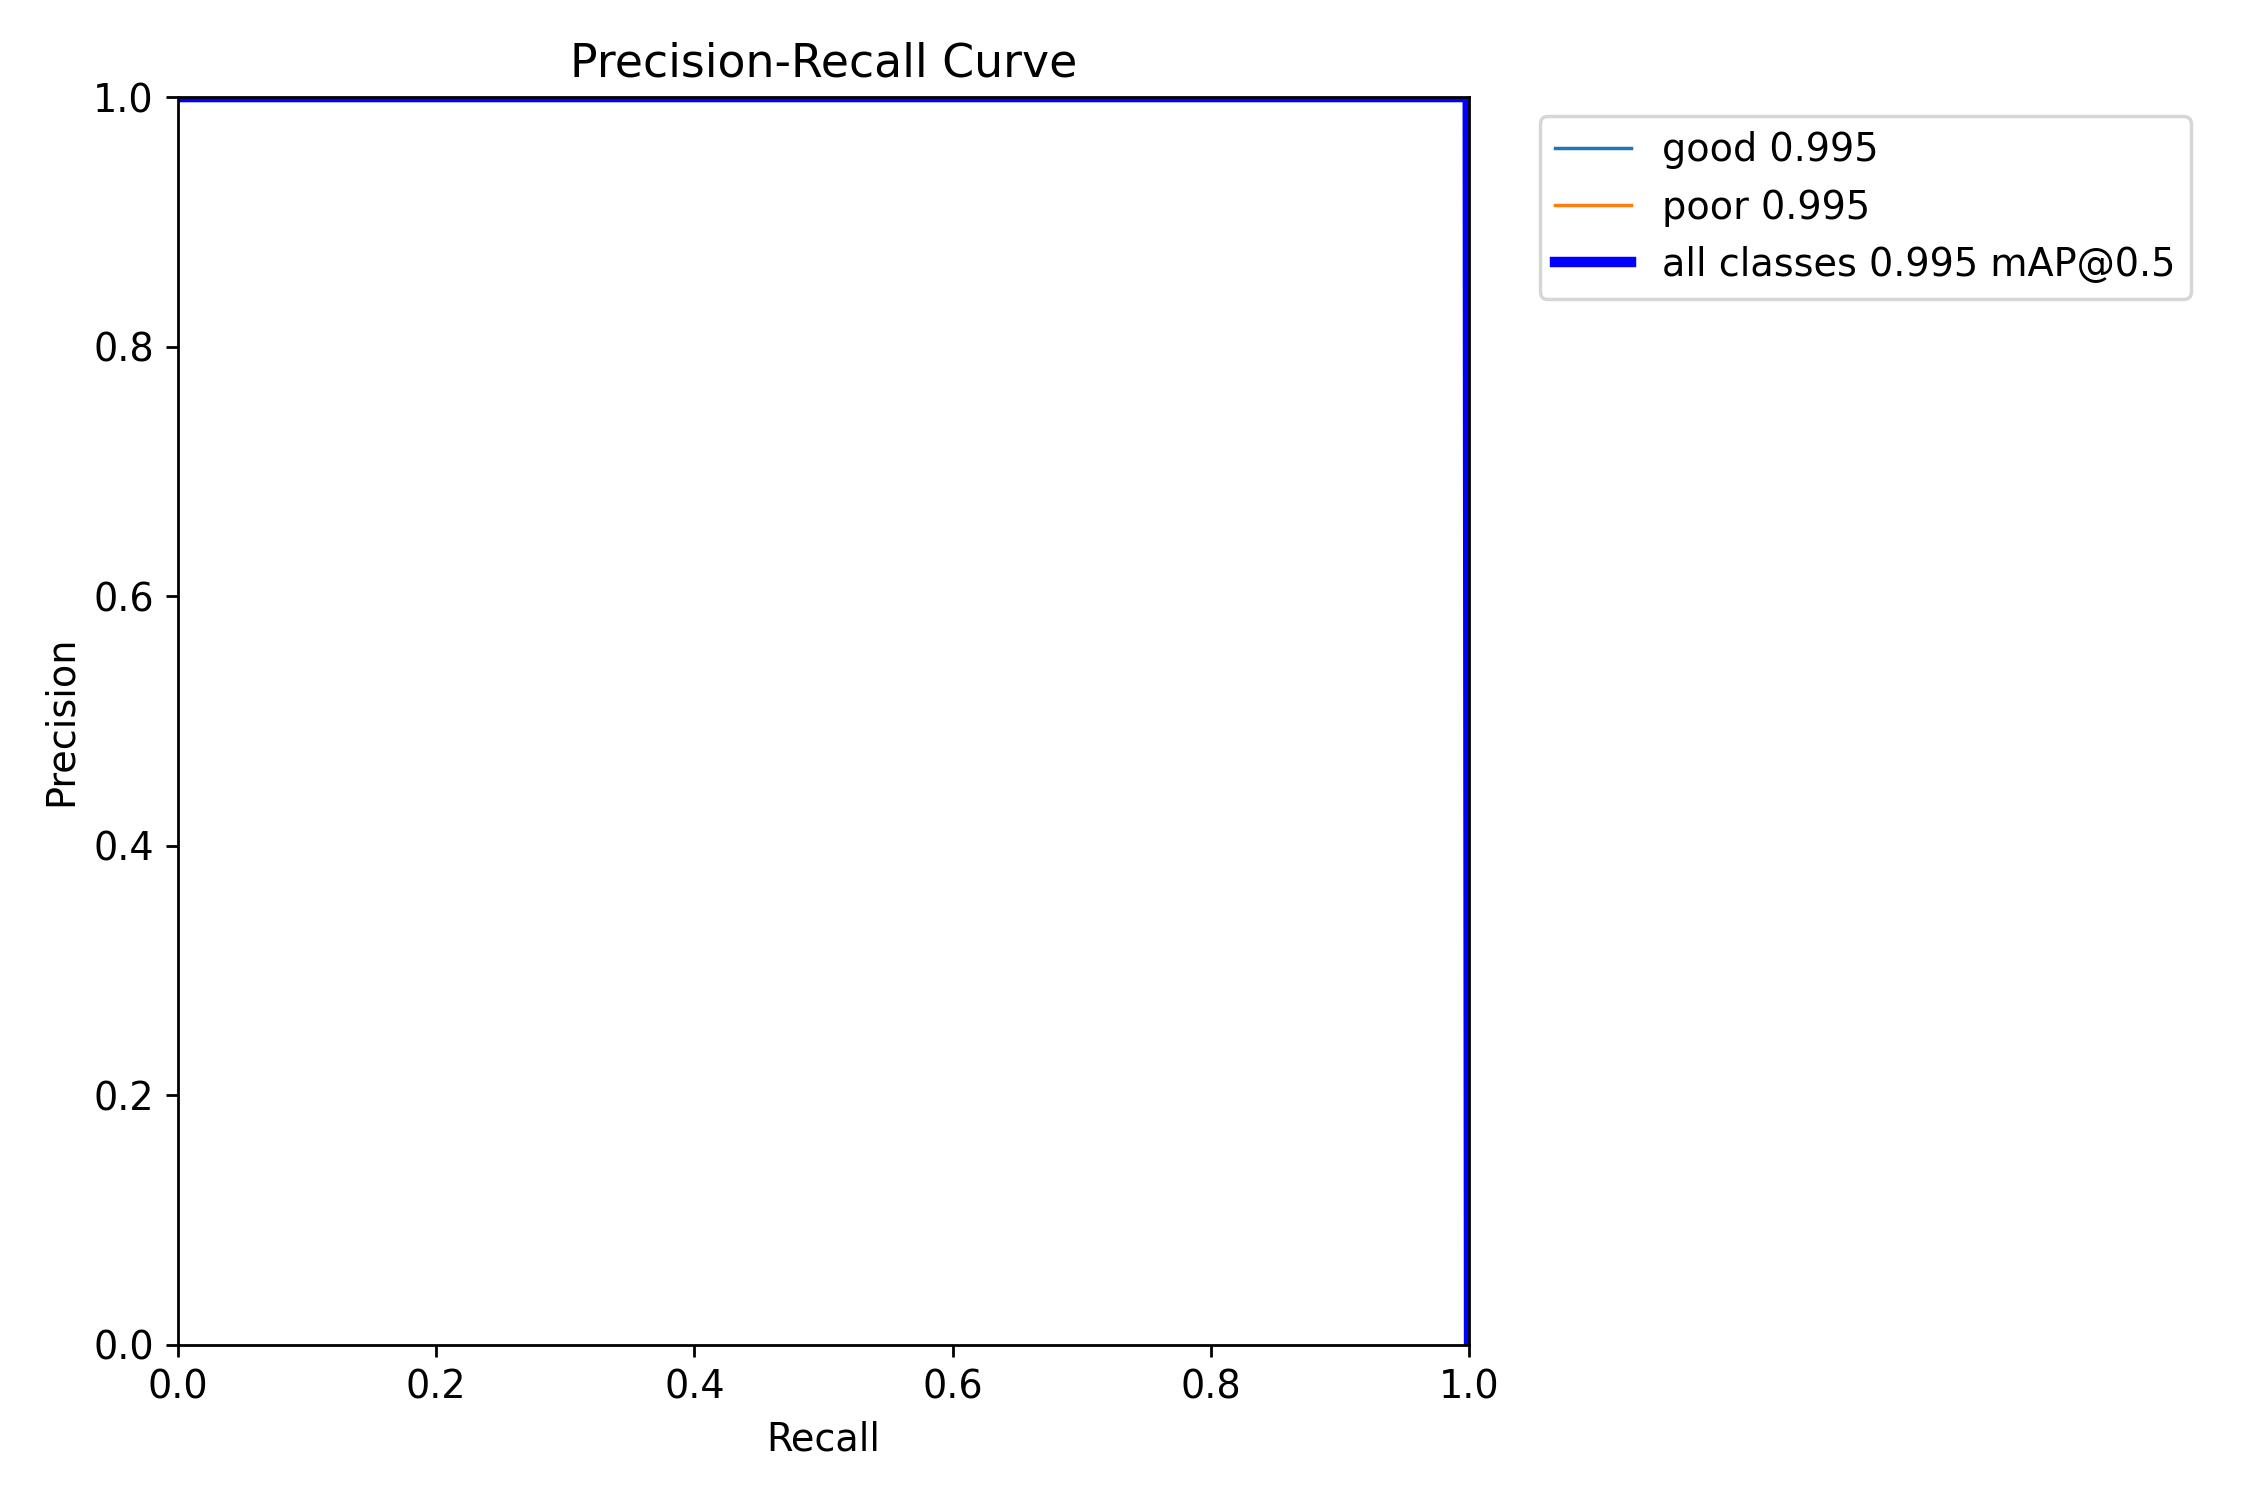

In [58]:
pr_curve_path = save_dir / "PR_curve.png"

# Open and display the PR curve image
if pr_curve_path.exists():
    img = Image.open(pr_curve_path)
    display(img)
else:
    print(f"PR curve not found at {pr_curve_path}")

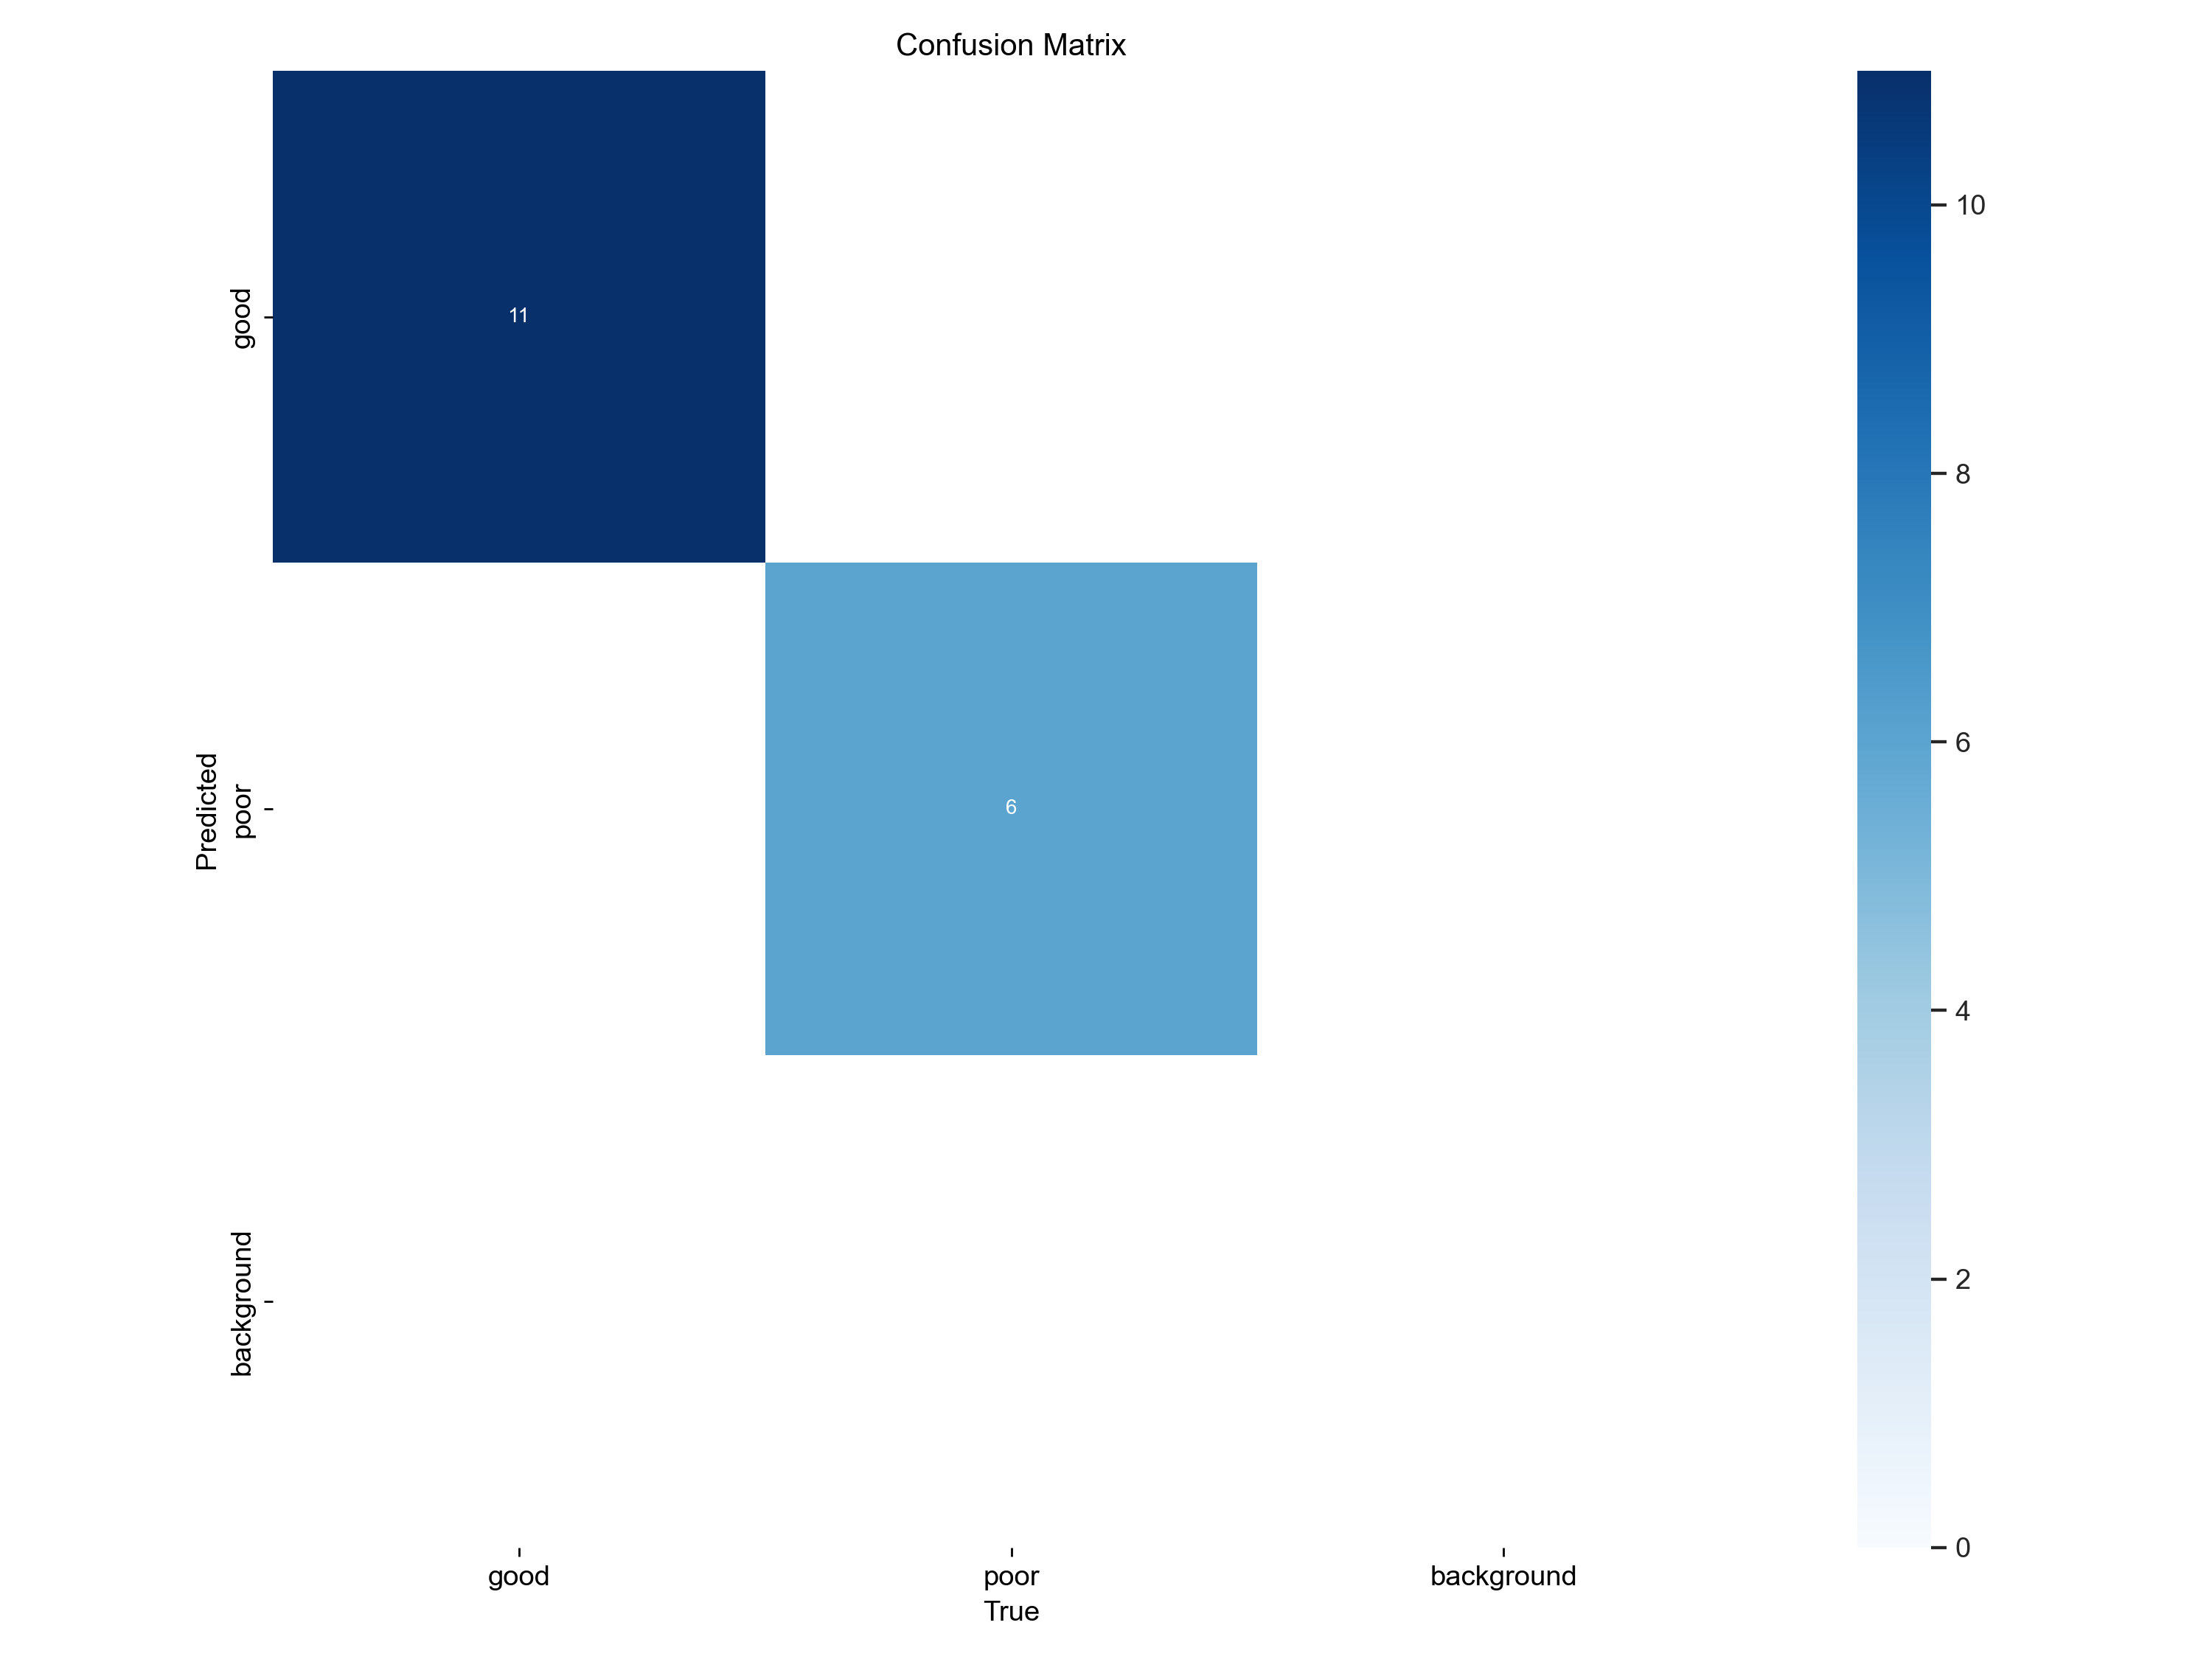

In [59]:
pr_curve_path = save_dir / "confusion_matrix.png"

# Open and display the PR curve image
if pr_curve_path.exists():
    img = Image.open(pr_curve_path)
    display(img)
else:
    print(f"PR curve not found at {pr_curve_path}")

In [61]:
images_dir = Path("train/resized/images")
image_path = images_dir / "Bj_baik (10).jpg"

# Make prediction
predict_results = saved_model.predict(
    source=image_path,
    conf=0.5,  # Confidence threshold
    save=True  # Save the image with bounding boxes
)

# Output results summary
print(f"Results type: {type(predict_results)}, length {len(predict_results)}")

# To access prediction details:
for r in predict_results:
    print(r.names)     # Class names
    print(r.boxes)     # Detected boxes
    print(r.probs)     # Class probabilities (if available)



image 1/1 C:\Users\Dickson\Cocoa Quality\train\resized\images\Bj_baik (10).jpg: 640x640 1 good, 387.3ms
Speed: 78.3ms preprocess, 387.3ms inference, 10.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
Results type: <class 'list'>, length 1
{0: 'good', 1: 'poor'}
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.8953])
data: tensor([[214.8091, 157.4168, 340.1087, 393.6143,   0.8953,   0.0000]])
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[277.4589, 275.5156, 125.2996, 236.1974]])
xywhn: tensor([[0.4335, 0.4305, 0.1958, 0.3691]])
xyxy: tensor([[214.8091, 157.4168, 340.1087, 393.6143]])
xyxyn: tensor([[0.3356, 0.2460, 0.5314, 0.6150]])
None
